Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
This is part of a release of experimental data determined at AstraZeneca on a set of compounds in the following assays: pKa, lipophilicity (LogD7.4), aqueous solubility, plasma protein binding (human, rat, dog , mouse and guinea pig), intrinsic clearance (human liver microsomes, human and rat hepatocytes). 

## Description of readout:
- **LOGD_74**: Octan-1-ol/water (pH7.4) distribution coefficent measured by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355.

## Data resource

**Reference**: https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/

**Raw data**: https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301363/

In [1]:
import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

# For downloading ChEMBL datasets
from chembl_webresource_client.new_client import new_client as client
from tqdm.auto import tqdm
import warnings
import pandas as pd

We can get the dataset directly from ChEMBL (https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/ gives the overall experimental data information, and subsequent numbers give data for a specific endpoint). The following map gives information on each:

In [2]:
# chembl_map = {
#     'CHEMBL3301362' : 'Most basic pKa value (pKa B1)', # 261
#     'CHEMBL3301363' : 'Octan-1-ol/water (pH7.4) distribution coefficent', # 4200
#     'CHEMBL3301364' : 'Solubility in pH7.4 buffer', #1763
#     'CHEMBL3301365' : '\% bound to plasma by equilibrium dialysis, human plasma', # PPB # 1614
#     'CHEMBL3301366' : '\% bound to plasma by equilibrium dialysis, rat plasma', # 717
#     'CHEMBL3301367' : '\% bound to plasma by equilibrium dialysis, dog plasma', # 244
#     'CHEMBL3301368' : '\% bound to plasma by equilibrium dialysis, mouse plasma', # 162
#     'CHEMBL3301369' : '\% bound to plasma by equilibrium dialysis, guinea pig plasma', # 91
#     'CHEMBL3301370' : 'Intrinsic clearance measured in human liver microsomes', #1102,
#     'CHEMBL3301371' : 'Intrinsic clearance measured in rat hepatocytes', # 837
#     'CHEMBL3301372' : 'Intrinsic clearance measured in human hepatocytes', # 408
# }

In [3]:
# load data
data = pd.read_parquet('gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301363_raw.parquet')
data

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,14759005,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
1,None,None,14759006,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
2,None,None,14759007,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.81
3,None,None,14759008,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.81
4,None,None,14759009,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,None,None,14770246,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
4196,None,None,14770247,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
4197,None,None,14770248,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8
4198,None,None,14770249,[],CHEMBL3301363,ASTRAZENECA: Octan-1-ol/water (pH7.4) distribu...,P,None,None,BAO_0000179,...,None,No relevant target,None,None,None,LogD7.4,None,None,None,1.8


If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [4]:
print(data.columns)

columns_to_keep = [
    "canonical_smiles",
    "standard_value",
]
data = data[columns_to_keep].copy()

# Convert the readout to numeric values
data["standard_value"] = pd.to_numeric(data["standard_value"])

# Rename columns
data = data.rename(
    columns={
        "canonical_smiles": "SMILES",
        "standard_value": "LOGD_74",
    }
)

data

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


,SMILES,LOGD_74
0,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,1.80
1,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,1.80
2,COc1cc2c(c(OC)c1OC)-c1ccc(O)cc1[C@@H](NC(C)=O)CC2,1.81
3,N#Cc1cccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl...,1.81
4,CCOC(=O)c1coc2ccccc2c1=O,1.81
...,...,...
4195,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,1.80
4196,COc1ccc(C(C)NC(=O)C2(N)CCN(c3ncnc4[nH]ccc34)CC...,1.80
4197,COc1cc(OC2CCNCC2)ccc1Nc1ncc(Cl)c(-c2cnc3ccccn2...,1.80
4198,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2ccc(C(F)(...,1.80


In [5]:
# Define data column names
endpoints = [
    'LOGD_74',
]
data_cols = endpoints
mol_col = 'SMILES'

### Run preliminary curation for data inspection

In [6]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True
)
data_look = curator()

2024-03-28 16:15:51.127 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column LOGD_74 using zscore. Please revise the data and consider remove the outliers. 
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


The curation detected 3 outliers in the data. Let's take a look at the distribution.

In [7]:
data_look.head()

,SMILES,LOGD_74,ORIGINAL_LOGD_74,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_LOGD_74,LOGD_74_zscore,LOGD_74_stereo_cliff
0,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,2.01,2.01,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,0007d9df4656b011caf3afc146b6b8fe44a8ea89,b8954faa941a4059fe1fba124a72ed36e95c7760,3,0,3,8,1,False,False,False,-0.287892,NaN
1,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,1.42,1.42,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,00134f769eb1a70818787bb15017c37d6cccf15d,daa9c2c86fbd71109aa6cd9dd9f333532b0c678e,5,1,4,32,2,False,False,False,-0.773197,NaN
2,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,4.20,4.20,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,0013b7daa7c92ed4adadeb46442b933c4c2f9718,bca4dc09156f36c5c03781a0451d69054eb57e76,1,1,0,2,2,True,False,False,1.513491,NaN
3,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,1.40,1.40,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,001ebcfbf1492c715075be2e3e8440a8f1961ae2,109dc7a7720a57255d15140982c56bb253838da5,2,0,2,4,1,False,False,False,-0.789648,NaN
4,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,3.69,3.69,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,003579fb1182f455ecc1ab4efbc8b566f9e576a4,4f67b12a8fc665ff1b810f835f4a5f1bd2c19290,1,1,0,2,2,True,False,False,1.093991,NaN


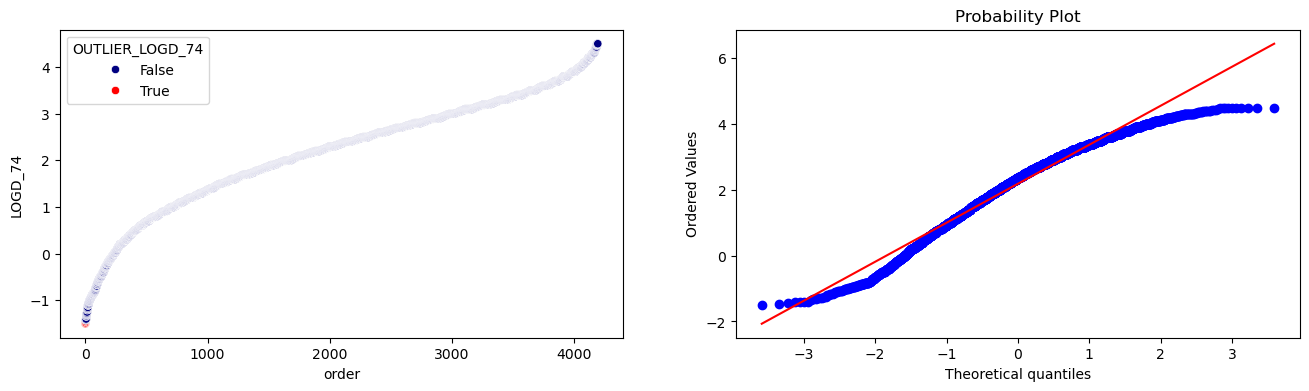

In [8]:
visualize_distribution(dataset=data_look, data_cols=data_cols);

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

### Check activity shift between stereoisomers

In [9]:
data_look[[col for col in data_look.columns if "stereo_cliff" in col]].sum()

LOGD_74_stereo_cliff    2
dtype: object

Two activity shifts were detected in the dataset. Let's identify them for later removal.

In [10]:
data_look[~data_look["LOGD_74_stereo_cliff"].isna()]

,SMILES,LOGD_74,ORIGINAL_LOGD_74,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_LOGD_74,LOGD_74_zscore,LOGD_74_stereo_cliff
3620,Cc1nc(C(=O)[C@@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)...,3.58,3.58,Cc1nc(C(=O)[C@@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)...,Cc1nc(C(=O)[C@@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)...,dd43a535c6ad8a7aa556705928eeb0661aee1eaa,22dc262e7e401f7c5c91b2218ce537783d7fd2c4,1,0,1,2,1,False,False,False,1.003511,True
3639,Cc1nc(C(=O)[C@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)s...,2.03,2.03,Cc1nc(C(=O)[C@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)s...,Cc1nc(C(=O)[C@H](C)Oc2ccc(SCCCCCc3ccccc3)cc2)s...,de5315fb3792a8ccc347e3b70146c225e38852cb,22dc262e7e401f7c5c91b2218ce537783d7fd2c4,1,0,1,2,1,False,False,False,-0.271441,True


### Check the molecules with undefined stereocenters

Note: feature currently not working

In [11]:
# data_look['mol'] = data_look['smiles'].apply(dm.to_mol) # Convert smiles to RDKit Mol object
# fig, _ = check_undefined_stereocenters(dataset=data_look)
# fig

In [12]:
# _[data_cols].boxplot(rot=90)

### Re-run curation, removing molecules as needed

In [13]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules that have undefined stereocenters and also show activity shift to the stereoisomers
    mask_stereo_undefined_mols=True,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)

print(f'size before curation: {len(data)}')
data_curated = curator_with_stereo()
print(f'size after curation: {len(data_curated)}')

size before curation: 4200


2024-03-28 16:15:58.637 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column LOGD_74 using zscore. Please revise the data and consider remove the outliers. 


size after curation: 4195


/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


In [14]:
# Drop molecules with stereo activity cliff
data_curated= data_curated.drop(data_curated[~data_curated["LOGD_74_stereo_cliff"].isna()].index)
data_curated

,SMILES,LOGD_74,ORIGINAL_LOGD_74,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_LOGD_74,LOGD_74_zscore,LOGD_74_stereo_cliff
0,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,2.01,2.01,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,0007d9df4656b011caf3afc146b6b8fe44a8ea89,b8954faa941a4059fe1fba124a72ed36e95c7760,3,0,3,8,1,False,False,False,-0.287892,NaN
1,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,1.42,1.42,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,C[C@H]1O[C@@H](n2cnc3c(N)nc(OCC4CC(F)(F)C4(F)F...,00134f769eb1a70818787bb15017c37d6cccf15d,daa9c2c86fbd71109aa6cd9dd9f333532b0c678e,5,1,4,32,2,False,False,False,-0.773197,NaN
2,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,4.20,4.20,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,FC(F)(F)c1cc(COCC(c2cccc(Cl)c2)N2CCNCC2)cc(C(F...,0013b7daa7c92ed4adadeb46442b933c4c2f9718,bca4dc09156f36c5c03781a0451d69054eb57e76,1,1,0,2,2,True,False,False,1.513491,NaN
3,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,1.40,1.40,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,COc1ccc(N2CCN(C(=O)[C@@H]3CCCC[C@H]3C(=O)NC3(C...,001ebcfbf1492c715075be2e3e8440a8f1961ae2,109dc7a7720a57255d15140982c56bb253838da5,2,0,2,4,1,False,False,False,-0.789648,NaN
4,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,3.69,3.69,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,CSCCC(NC(=O)c1sccc1Cl)c1nc2ccccc2[nH]1,003579fb1182f455ecc1ab4efbc8b566f9e576a4,4f67b12a8fc665ff1b810f835f4a5f1bd2c19290,1,1,0,2,2,True,False,False,1.093991,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,3.20,3.20,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,CC(=O)N1CCN(CCOc2ccc(C3CCN(c4ccc5nnc(C(F)(F)F)...,ffb833f42c9d470a03cbea466fa2c7496f348eb4,70cf3d8997770c88ed01cc1c7b9488d78427bdee,0,0,0,1,1,False,True,False,0.690942,NaN
4191,O=c1[nH]c2c(O)ccc([C@@H](O)CNCCCSCCNCCc3cccc(C...,1.06,1.06,O=c1[nH]c2c(O)ccc([C@@H](O)CNCCCSCCNCCc3cccc(C...,O=c1[nH]c2c(O)ccc([C@@H](O)CNCCCSCCNCCc3cccc(C...,ffc6547fe2c544895720224fd9e3c4a180ca4358,768cc67e1873c49209443cec3699f97b256a629a,1,0,1,2,1,False,False,False,-1.069315,NaN
4192,Nc1ccc(OCc2ccccc2)cc1,2.20,2.20,Nc1ccc(OCc2ccccc2)cc1,Nc1ccc(OCc2ccccc2)cc1,ffcbb6581f6a80c8ecf8ef96108696dcc5824839,a82a1d8b3bdd4fb5ade3d6701c6ccad9cfacb46b,0,0,0,1,1,False,True,False,-0.131608,NaN
4193,NC1=NN(c2cccc(C(F)(F)F)c2)CC1,2.55,2.55,NC1=NN(c2cccc(C(F)(F)F)c2)CC1,NC1=NN(c2cccc(C(F)(F)F)c2)CC1,ffdb52ce9d95429e689a69ccd9a356007f0479dc,41b81806179f3ca3fb16699efe0929a620912060,0,0,0,1,1,False,True,False,0.156284,NaN


In [15]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'LOGD_74': ColumnAnnotation(description="Octan-1-ol/water (pH7.4) distribution coefficent.",
                                ),
}

In [16]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name="AstraZeneca_LogD_74",
    description="Octan-1-ol/water (pH7.4) distribution coefficent experiment data released by AstraZeneca",
    source="https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301363/",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Shawn Whitfield", slug="swhitfield"),
    license=License(id="MIT"),
    user_attributes={"year": "2016"},
)

In [17]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

/Users/shawn.whitfield/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


['/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmp6_a2vdcb/dataset/table.parquet',
 '/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmp6_a2vdcb/dataset/dataset.json']

In [18]:
# data_curated.to_parquet(f'./data/CHEMBL3301363_curated.parquet') # Save just in case. Requires a data folder.

In [19]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [20]:
# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)